In [1]:
import os
from netCDF4 import Dataset
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime

/Users/anthonychiado/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
dataframes = pd.DataFrame(columns=['year', 'simulation', 'region', 'PRECT'])

def process_region(data, region, lat_slice, lon_slice):
    # Weight and average for the specified region
    ds_region = data.sel(lat=lat_slice, lon=lon_slice)
    weights_region = np.cos(np.deg2rad(ds_region['lat']))
    weights_region.name = 'weights'
    ds_weighted_region = ds_region['PRECT'].weighted(weights_region)
    mean_sst_region = ds_weighted_region.mean(dim=['lat', 'lon'])
    ds_region = mean_sst_region

    # Filter months of interest (Nov, Dec, Jan, Feb, Mar)
    month_list = [True if month in [11, 12, 1, 2, 3] else False for month in data['time.month']]
    ds_region = ds_region.loc[{'time': month_list}] 

    # Create a new variable for grouping Nov, Dec and Jan, Feb, March from the following year
    # e.g. Nov, Dec 1940 and Jan, Feb, March 1941 -> 1940
    ds_region['year_group'] = (
        ds_region['time.year'] + (ds_region['time.month'] >= 11) - 1
    ).astype(str)

    # Calculate sum PRECT for each year
    ds_region = ds_region.groupby('year_group').sum(dim='time')

    # Convert m/s to mm/day (1 m/s = 86400000 mm/day)
    ds_region = ds_region * 86400000

    # Append to the DataFrame
    df = pd.DataFrame({
        'year': ds_region.coords['year_group'].values,
        'simulation': data.attrs['case'][-8:],
        'region': region,
        'PRECT': ds_region.values
    })

    return df

def calc_prect(PRECT_data_fn):

    global dataframes
    
    ds = xr.open_dataset(PRECT_data_fn, decode_times=False)

    reference_date = pd.to_datetime("1850-01-01")
    start_date = reference_date + datetime.timedelta(days = float(ds.time[0]))

    ds['time'] = pd.date_range(start=start_date, periods=ds.sizes['time'], freq='MS')

    south_df = process_region(ds, 'South', slice(32.0, 34.9), slice(239.4, 245.6))
    central_df = process_region(ds, 'Central', slice(34.9, 38.6), slice(236.9, 243.1))
    north_df = process_region(ds, 'North', slice(38.8, 42.2), slice(235.6, 240.6))

    # Append the DataFrames to your main list
    dataframes = pd.concat([dataframes, north_df, central_df, south_df])
    return dataframes

In [3]:
# Iterate through each file in the directory
directory_path = "/Users/anthonychiado/Desktop/work/uva/capstone/"

for filename in os.listdir(directory_path):
    if filename.endswith(".nc"):
        file_path = os.path.join(directory_path, filename)
        calc_prect(file_path)

/var/folders/6d/l8lllpwx5ks5ds1kv6dqysww0000gn/T/ipykernel_2709/3124844706.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframes = pd.concat([dataframes, north_df, central_df, south_df])


In [7]:
dataframes = dataframes.groupby(['year', 'simulation', 'region'])['PRECT'].sum().reset_index()
dataframes = dataframes[(dataframes['year'] != '1939') & (dataframes['year'] != '2014')]
dataframes

,year,simulation,region,PRECT
300,1940,1001.001,Central,12.205217
301,1940,1001.001,North,15.767306
302,1940,1001.001,South,7.383293
303,1940,1011.001,Central,13.442538
304,1940,1011.001,North,21.679625
...,...,...,...,...
22495,2013,1301.019,North,18.776388
22496,2013,1301.019,South,5.163358
22497,2013,1301.020,Central,13.660042
22498,2013,1301.020,North,19.974801


### export to netcdf

In [9]:
# convert the DataFrame to an xarray.Dataset
output_dataset = xr.Dataset(
    {'PRECT': (['index'], dataframes['PRECT'])},
    coords={
        'year': (['index'], dataframes['year']),
        'simulation': (['index'], dataframes['simulation']),
        'region': (['index'], dataframes['region'])
    }
)

output_dataset['year'] = dataframes['year'].unique()
output_dataset['simulation'] = dataframes['simulation'].unique()
output_dataset['region'] = dataframes['region'].unique()

In [10]:
# save as netcdf
output_dataset.to_netcdf('/Users/anthonychiado/Desktop//work/uva/capstone/prect_data.nc')

### sanity plots

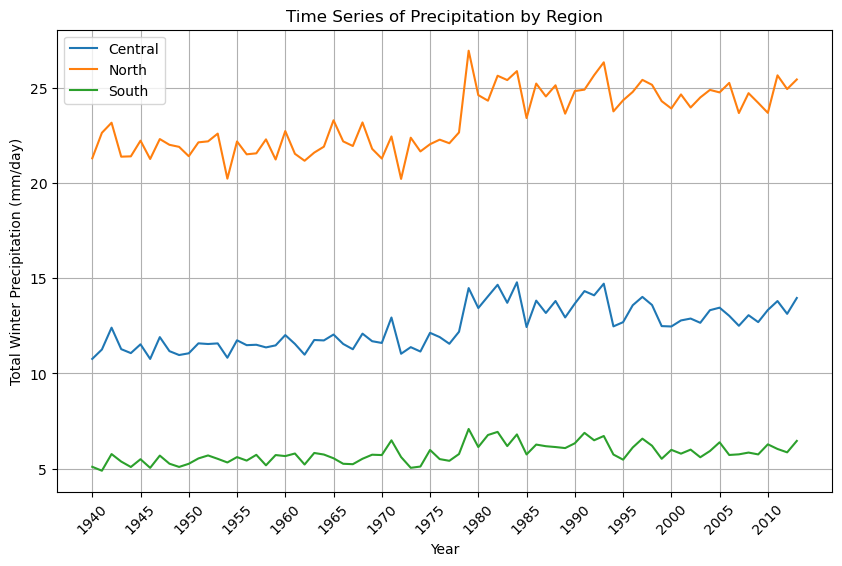

In [8]:
aggregated_data = dataframes.groupby(['year', 'region'])['PRECT'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

for region, data in aggregated_data.groupby('region'):
    plt.plot(data['year'], data['PRECT'], label=region)

plt.xlabel('Year')
plt.ylabel('Total Winter Precipitation (mm/day)')
plt.title('Time Series of Precipitation by Region')

x_ticks = data['year'][::5]
plt.xticks(ticks=x_ticks, rotation=45)

plt.legend()
plt.grid(True)

plt.show()